<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
!pip install -U scikit-learn

In [3]:
from sklearn import preprocessing

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [ ]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object


In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

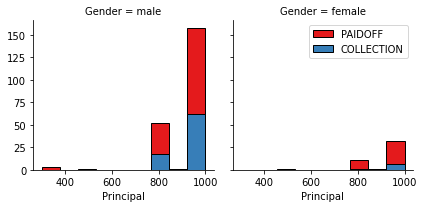

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

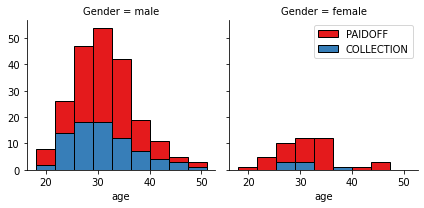

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


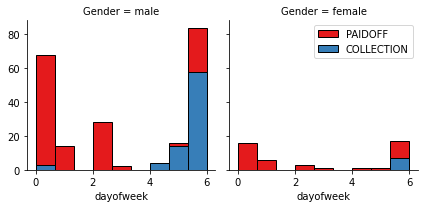

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

87 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1 and change Bechalor to Bachelor


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['education'].replace(to_replace=['Bechalor'], value='Bachelor', inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

### over 70% payoff the loan for education Bachelor degree or below but only 50% payoff their loan for Master or Above

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bachelor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [18]:
X1 = Feature.copy()
X1.head()

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [19]:
X1 = X1.values
X1

array([[1000,   30,   45, ...,    0,    1,    0],
       [1000,   30,   33, ...,    1,    0,    0],
       [1000,   15,   27, ...,    0,    0,    1],
       ...,
       [ 800,   15,   39, ...,    0,    0,    1],
       [1000,   30,   28, ...,    0,    0,    1],
       [1000,   30,   26, ...,    0,    0,    1]])

What are our lables?


In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [21]:
df1 = df.copy()
df1['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y1 = df1['loan_status'].values
y1[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [22]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Training Set for building Models

In [23]:
# KNN Training and Test Set

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print('Model: KNN')
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Model: KNN
Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [24]:
# Decision Tree Training
XD_train, XD_test, yD_train, yD_test = train_test_split(X1, y, test_size=0.20, random_state = 4)
print('Model: Decison Tree')
print ('Train set:', XD_train.shape,  yD_train.shape)
print ('Test set:', XD_test.shape,  yD_test.shape)

Model: Decison Tree
Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [25]:
# SVM Training and Test Set
XS_train, XS_test, yS_train, yS_test =  train_test_split(X1, y1, test_size=0.20, random_state = 4)
print('Model: SVM')
print ('Train set:', XS_train.shape,  yS_train.shape)
print ('Test set:', XS_test.shape,  yS_test.shape)

Model: SVM
Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [44]:
# Logistic Regression Training and Test Set 
XL_train, XL_test, yL_train, yL_test =  train_test_split(X, y1, test_size=0.20, random_state = 4)
print('Model: Logistic Regression')
print ('Train set:', XL_train.shape,  yL_train.shape)
print ('Test set:', XL_test.shape,  yL_test.shape)

Model: Logistic Regression
Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import scipy.optimize as opt

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [27]:
Ks = 10
mean_acc = np.zeros((Ks-1))
js_score = np.zeros((Ks-1))
f_score = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    i = int(n)
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    js_score[n-1] = jaccard_score(y_test, yhat, pos_label='PAIDOFF')
    f_score[n-1] = f1_score(y_test, yhat, pos_label='PAIDOFF', average='binary')
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print("Accuracy values are ", mean_acc)
print("The Jaccard Scores are ", js_score)
print("F1 Scores are ", f_score)


Accuracy values are  [0.64285714 0.58571429 0.74285714 0.7        0.74285714 0.71428571
 0.8        0.75714286 0.74285714]
The Jaccard Scores are  [0.6031746  0.52459016 0.71428571 0.6557377  0.71875    0.67741935
 0.77419355 0.72131148 0.73134328]
F1 Scores are  [0.75247525 0.68817204 0.83333333 0.79207921 0.83636364 0.80769231
 0.87272727 0.83809524 0.84482759]


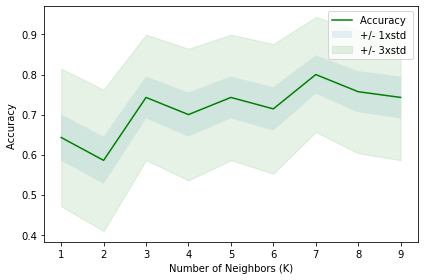

In [28]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### The best k for the K nearest neighbor

In [29]:
print("The best accuracy was with", mean_acc.max(), "with k = ", mean_acc.argmax()+1)
print("The best Jaccard score ", js_score.max(), " with k = ", js_score.argmax()+1)
print("The best F1 score ", f_score.max(), " with k = ", f_score.argmax() + 1)


The best accuracy was with 0.8 with k =  7
The best Jaccard score  0.7741935483870968  with k =  7
The best F1 score  0.8727272727272727  with k =  7


##  K = 7 is the model we will use for K Nearest Neighbor

# Decision Tree


In [30]:
Kd = 10
meanD = np.zeros((Ks-1))
jDscore = np.zeros((Ks - 1))
fDscore = np.zeros((Ks - 1))

for n in range(1,Kd):
    i = n+3
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    drugTree.fit(XD_train,yD_train)
    predTree = drugTree.predict(XD_test)
    meanD[n-1] = metrics.accuracy_score(yD_test, predTree)
    jDscore[n-1] = jaccard_score(yD_test, predTree, pos_label='PAIDOFF')
    fDscore[n-1] = f1_score(y_test, predTree, pos_label='PAIDOFF', average='binary')

print("Accuracy values are ", meanD)
print("The Jaccard Scores are ", jDscore)
print("F1 Scores are ", fDscore)    


Accuracy values are  [0.78571429 0.78571429 0.61428571 0.61428571 0.64285714 0.77142857
 0.75714286 0.75714286 0.65714286]
The Jaccard Scores are  [0.78571429 0.78571429 0.57142857 0.57142857 0.58333333 0.76811594
 0.75362319 0.75362319 0.625     ]
F1 Scores are  [0.88       0.88       0.72727273 0.72727273 0.73684211 0.86885246
 0.85950413 0.85950413 0.76923077]


In [31]:
print("The best accuracy was with", meanD.max(), "with k = ", meanD.argmax()+4)
print("The best Jaccard score ", jDscore.max(), " with k = ", jDscore.argmax()+4)
print("The best F1 score ", fDscore.max(), " with k = ", fDscore.argmax() + 4)


The best accuracy was with 0.7857142857142857 with k =  4
The best Jaccard score  0.7857142857142857  with k =  4
The best F1 score  0.88  with k =  4


### Decision Tree, Maximum Depth = 4

In [32]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree.fit(XD_train,yD_train)
predTree = drugTree.predict(XD_test)

In [33]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

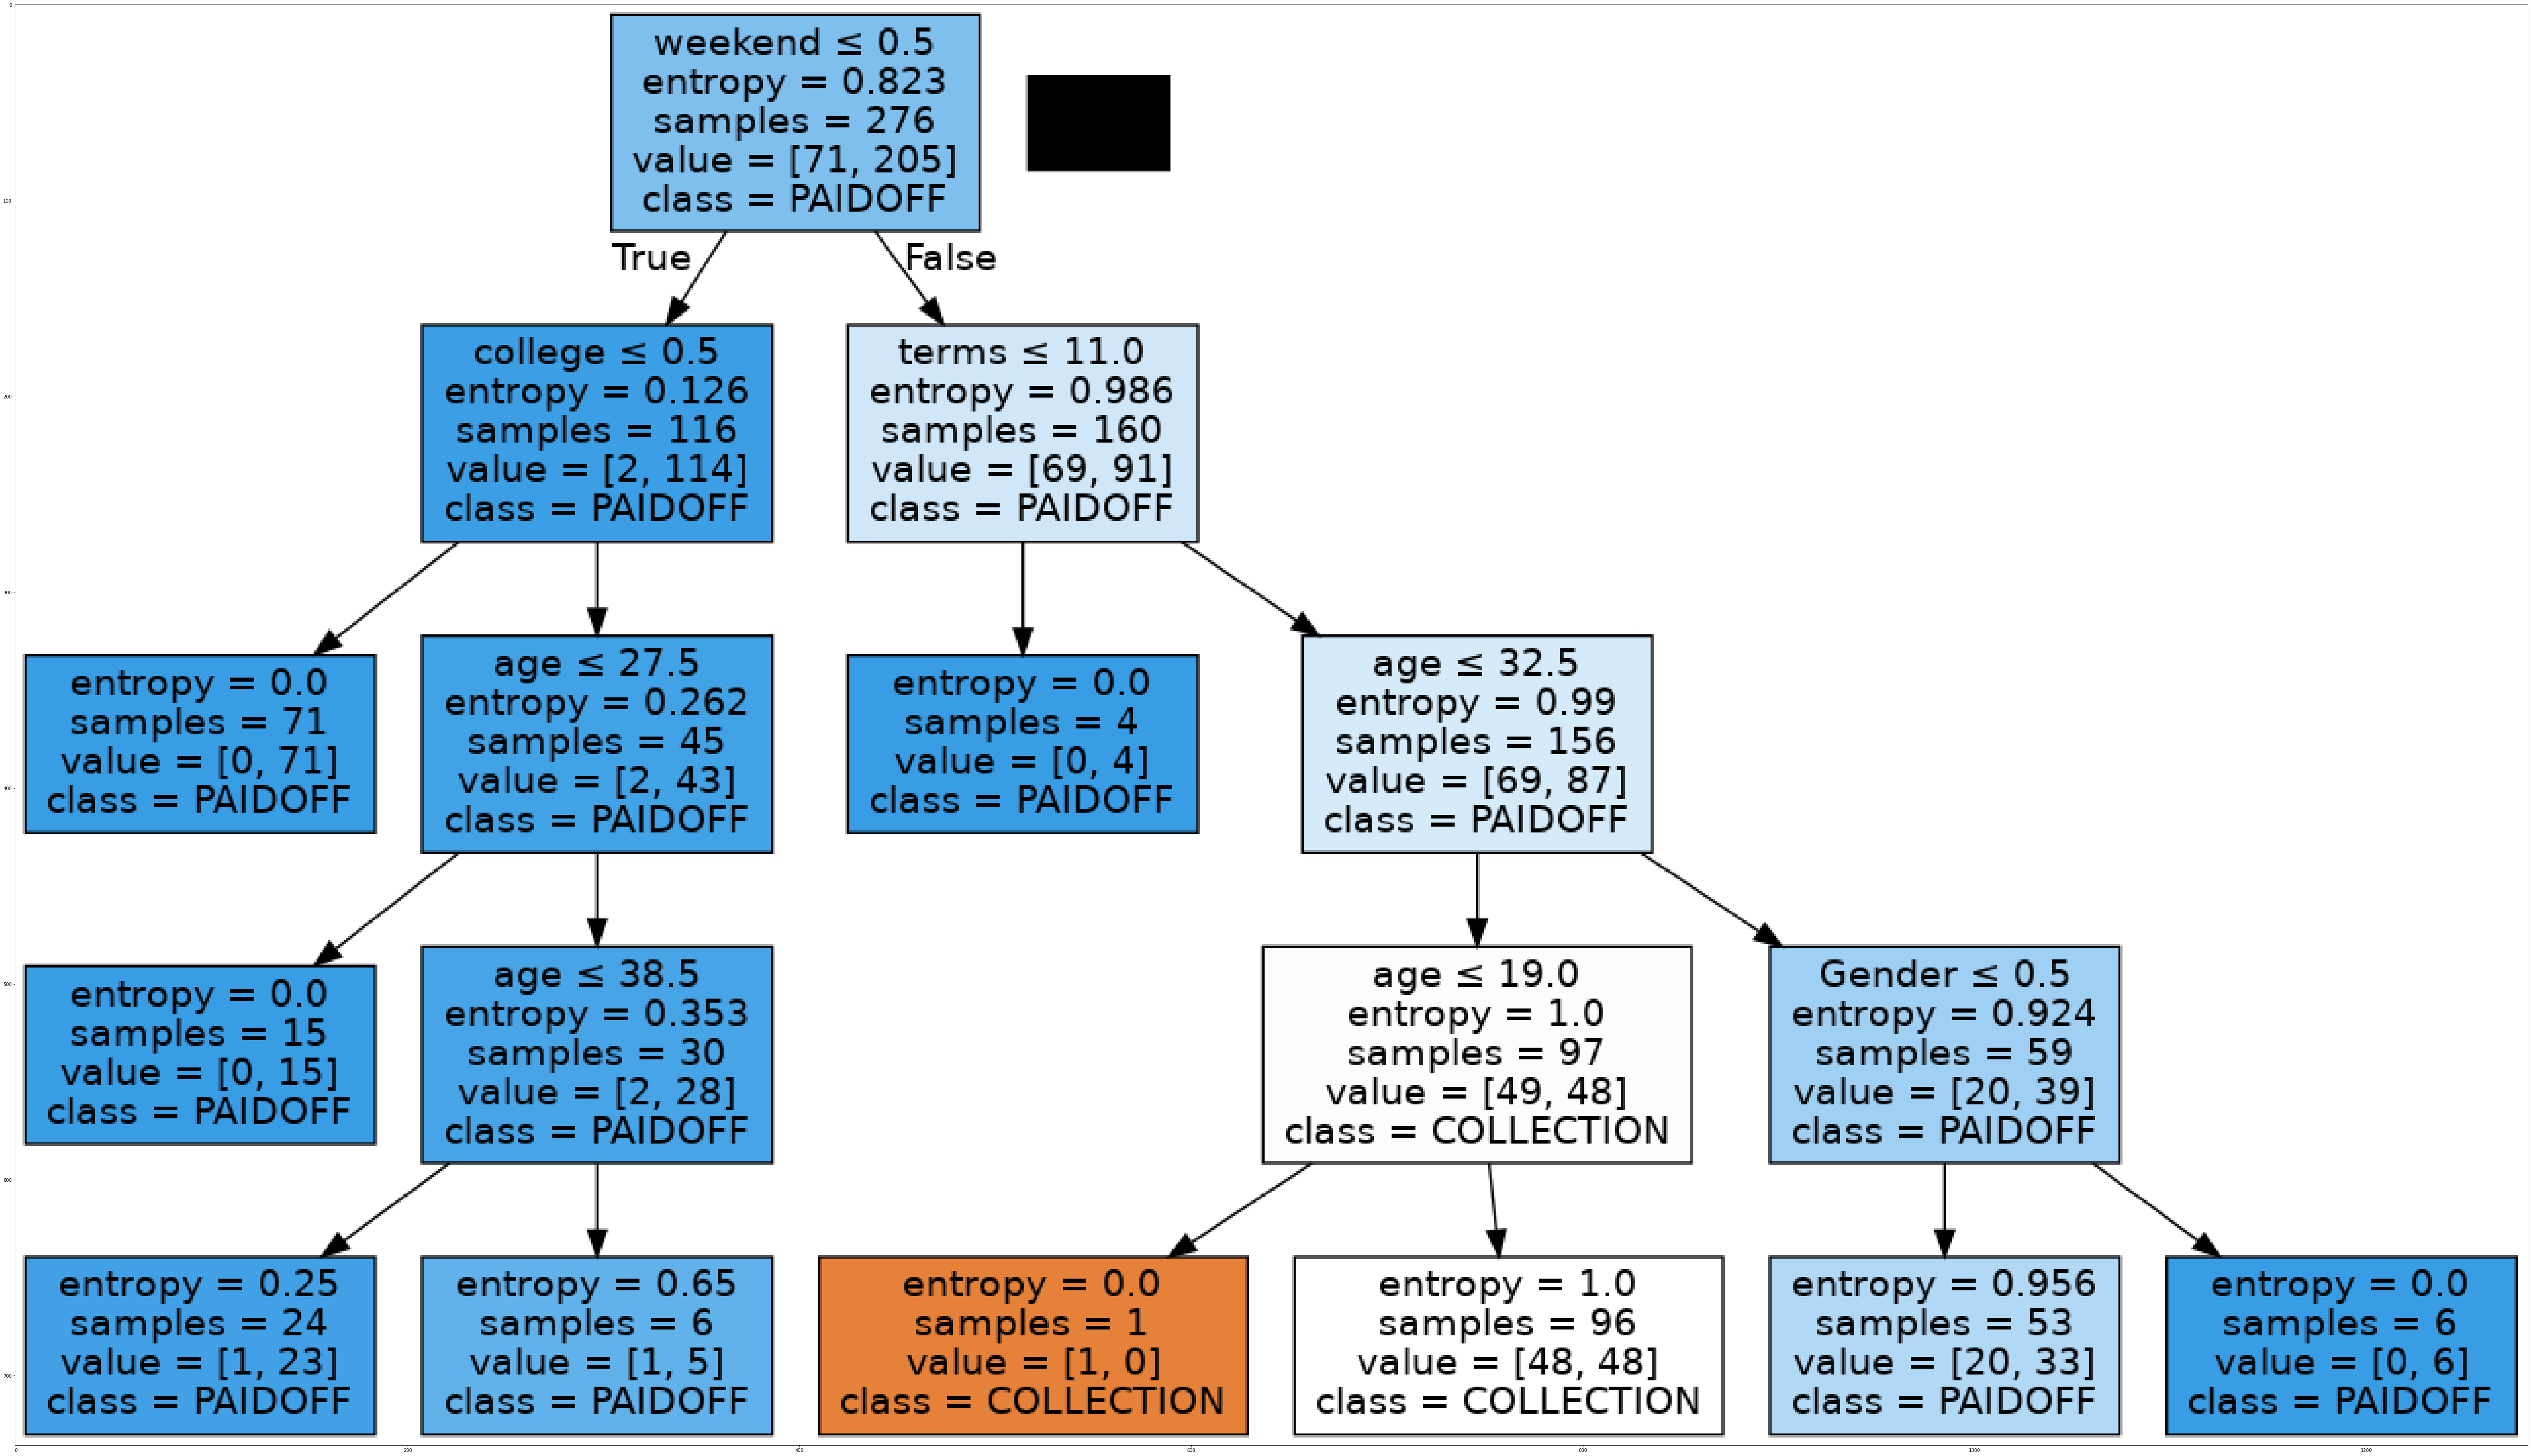

In [34]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = ['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bachelor', 'High School or Below', 'college']
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(yD_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [41]:
from sklearn import svm
svmtype = ['rbf', 'linear', 'sigmoid']
Kv = 4
meana = np.zeros((Kv-1))
jV_score = np.zeros((Kv-1))
fV_score = np.zeros((Kv-1))

for n in range(1, Kv):
    
    clf = svm.SVC(kernel=svmtype[n-1], gamma='auto')
    clf.fit(XS_train, yS_train)
    yhatS = clf.predict(XS_test)
    meana[n-1] = metrics.accuracy_score(yS_test, yhatS)
    jV_score[n-1] = jaccard_score(yS_test, yhatS, pos_label=0)
    fV_score[n-1] = f1_score(yS_test, yhatS, pos_label=0, average='binary')

    
print("The accuracy is ", meana)
print("Jaccard score ", jV_score)
print("F1 Score ", fV_score)

The accuracy is  [0.75714286 0.78571429 0.78571429]
Jaccard score  [0.75362319 0.78571429 0.78571429]
F1 Score  [0.85950413 0.88       0.88      ]


In [42]:
print("The best accuracy was with", meana.max(), "with kernal = ", svmtype[meana.argmax()])
print("The best Jaccard score ", jV_score.max(), " with kernal = ", svmtype[jV_score.argmax()])
print("The best F1 score ", fV_score.max(), " with kernal = ", svmtype[fV_score.argmax()])

The best accuracy was with 0.7857142857142857 with kernal =  linear
The best Jaccard score  0.7857142857142857  with kernal =  linear
The best F1 score  0.88  with kernal =  linear


### The linear kernal for Support Vector Machine

# Logistic Regression


In [99]:
logReg = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
Kl = 6
meanl = np.zeros((Kl-1))
jL_score = np.zeros((Kl-1))
fL_score = np.zeros((Kl-1))
ll_score = np.zeros((Kl-1))
for n in range(1, Kl):
    
    LR = LogisticRegression(C=0.01, solver=logReg[n-1]).fit(XL_train,yL_train)
    yhatL = LR.predict(XL_test)
    yhat_prob = LR.predict_proba(XL_test)
    meanl[n-1] = metrics.accuracy_score(yL_test, yhatL)
    jL_score[n-1] = jaccard_score(yL_test, yhatL, pos_label=0)
    fL_score[n-1] = f1_score(yL_test, yhatL, pos_label=0, average='binary')
    ll_score[n-1] = log_loss(yL_test, yhat_prob)
    
print("The accuracy is ", meanl)
print("Jaccard score ", jL_score)
print("F1 Score ", fL_score)
print("Log Loss ",ll_score)




The accuracy is  [0.78571429 0.78571429 0.68571429 0.78571429 0.78571429]
Jaccard score  [0.78571429 0.78571429 0.67647059 0.78571429 0.78571429]
F1 Score  [0.88       0.88       0.80701754 0.88       0.88      ]
Log Loss  [0.4920178  0.49201798 0.57722876 0.4920169  0.49202097]


In [100]:
print("The best accuracy was with", meanl.max(), "with kernal = ", logReg[meanl.argmax()])
print("The best Jaccard score ", jV_score.max(), " with kernal = ", logReg[jV_score.argmax()])
print("The best F1 score ", fV_score.max(), " with kernal = ", logReg[fV_score.argmax()])
print("The best Log loss score ", ll_score.max(), " with kernal = ", logReg[ll_score.argmax()])

The best accuracy was with 0.7857142857142857 with kernal =  newton-cg
The best Jaccard score  0.7857142857142857  with kernal =  lbfgs
The best F1 score  0.88  with kernal =  lbfgs
The best Log loss score  0.5772287609479654  with kernal =  liblinear


### Logistic Regression solver = lbfgs

# Model Evaluation using Test set


First, download and load the test set:


In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [50]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [57]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['education'].replace(to_replace=['Bechalor'], value='Bachelor', inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bachelor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bachelor,male,6,1


In [72]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Featurex = test_df[['Principal','terms','age','Gender','weekend']]
Featurex = pd.concat([Featurex,pd.get_dummies(test_df['education'])], axis=1)
Featurex.drop(['Master or Above'], axis = 1,inplace=True)
Featurex.head()

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [73]:
X2_N = Featurex
X2_N[0:5]

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [80]:
X2 = Featurex.copy()
X2 = X2.values
X2[0:5]


array([[1000,   30,   50,    1,    0,    1,    0,    0],
       [ 300,    7,   35,    0,    1,    0,    0,    0],
       [1000,   30,   43,    1,    1,    0,    1,    0],
       [1000,   30,   26,    0,    1,    0,    0,    1],
       [ 800,   15,   29,    0,    1,    1,    0,    0]])

In [81]:
y2_L = test_df['loan_status'].values
y2_L[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [82]:
test_df2 = test_df.copy()
test_df2['loan_status'].replace(to_replace=['PAIDOFF', 'COLLECTION'], value=[0, 1],inplace=True)
y2 = test_df2['loan_status'].values
y2[0:5]

array([0, 0, 0, 0, 0])

In [83]:
X2_N = preprocessing.StandardScaler().fit(X2).transform(X2)
X2_N[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [90]:
d={"Model":["KNN", "Decision Tree", "SVM", "Logistic Regression"], "Jaccard":[0.0, 0.0, 0.0, 0.0], "F1-score":[0.0, 0.0, 0.0, 0.0], "Log Loss":[np.nan, np.nan, np.nan, 0.0]}
eval = pd.DataFrame(data = d)
eval.head()

,Model,Jaccard,F1-score,Log Loss
0,KNN,0.0,0.0,NaN
1,Decision Tree,0.0,0.0,NaN
2,SVM,0.0,0.0,NaN
3,Logistic Regression,0.0,0.0,0.0


### KNN Model k= 7

In [95]:

neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
yhat=neigh.predict(X2_N)

j = jaccard_score(y2_L, yhat, pos_label='PAIDOFF')
f= f1_score(y2_L, yhat, pos_label='PAIDOFF', average='binary')
eval.iloc[0] = {'Model':'KNN', 'Jaccard':j, 'F1-score':f}
eval.head()


,Model,Jaccard,F1-score,Log Loss
0,KNN,0.666667,0.8,NaN
1,Decision Tree,0.000000,0.0,NaN
2,SVM,0.000000,0.0,NaN
3,Logistic Regression,0.000000,0.0,0.0


### Decision Tree maximum depth; 4

In [97]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree.fit(XD_train,yD_train)
predTree = drugTree.predict(X2)
j = jaccard_score(y2_L, predTree, pos_label='PAIDOFF')
f = f1_score(y2_L, predTree, pos_label='PAIDOFF', average='binary')
eval.iloc[1] = {'Model':'Decision Tree', 'Jaccard':j, 'F1-score':f}
eval.head()

,Model,Jaccard,F1-score,Log Loss
0,KNN,0.666667,0.800000,NaN
1,Decision Tree,0.688889,0.815789,NaN
2,SVM,0.000000,0.000000,NaN
3,Logistic Regression,0.000000,0.000000,0.0


### Support Vector Machine

In [98]:
clf = svm.SVC(kernel='linear', gamma='auto')
clf.fit(XS_train, yS_train)
yhatS = clf.predict(X2)
j = jaccard_score(y2, yhatS, pos_label=0)
f = f1_score(y2, yhatS, pos_label=0, average='binary')
eval.iloc[2] = {'Model':'SVM', 'Jaccard':j, 'F1-score':f}
eval.head()

,Model,Jaccard,F1-score,Log Loss
0,KNN,0.666667,0.800000,NaN
1,Decision Tree,0.688889,0.815789,NaN
2,SVM,0.740741,0.851064,NaN
3,Logistic Regression,0.000000,0.000000,0.0


### Logistic Regression

In [102]:
LR = LogisticRegression(C=0.01, solver='lbfgs').fit(XL_train,yL_train)
yhatL = LR.predict(X2_N)
yhat_prob = LR.predict_proba(X2_N)
j = jaccard_score(y2, yhatL, pos_label=0)
f = f1_score(y2, yhatL, pos_label=0, average='binary')
l = log_loss(y2, yhat_prob)
eval.iloc[3] = {'Model': 'Logistic Regression', 'Jaccard':j, 'F1-score':f, 'Log Loss':l}
eval.head()

,Model,Jaccard,F1-score,Log Loss
0,KNN,0.666667,0.800000,NaN
1,Decision Tree,0.688889,0.815789,NaN
2,SVM,0.740741,0.851064,NaN
3,Logistic Regression,0.740741,0.851064,0.516366


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
